# [사람인](https://www.saramin.co.kr/) 채용공고 크롤링

### notebook ver

검색된 정보들 가져오기

[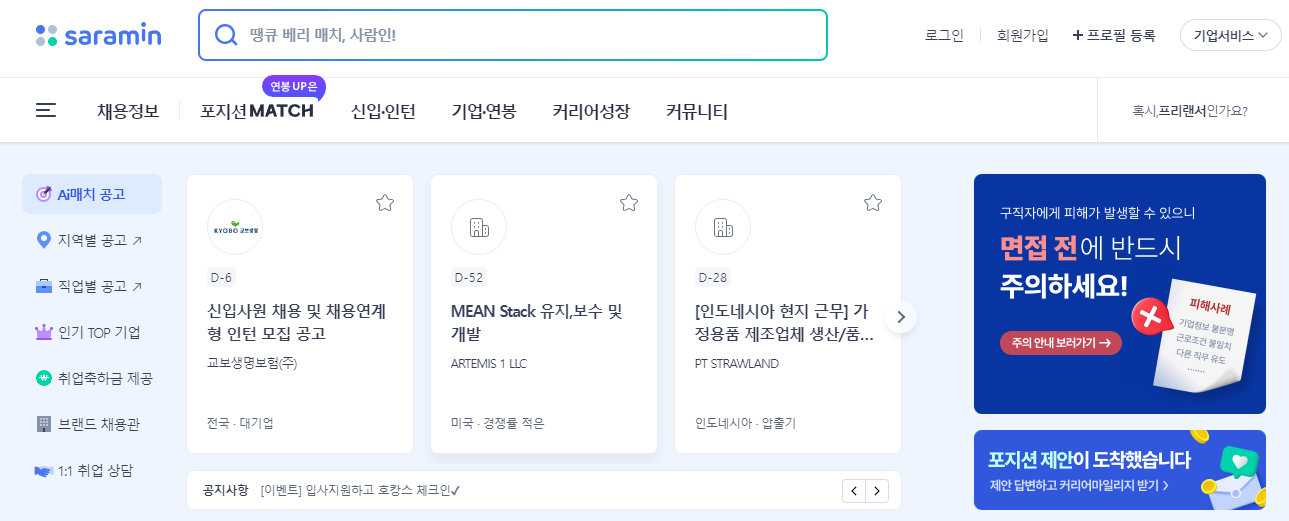](https://www.saramin.co.kr/)

## Env

selenium 설치

In [12]:
# !conda install selenium -y

[chrome 버전에 맞는 driver 다운로드](https://chromedriver.chromium.org/downloads)

압축을 풀고 chrome.exe를 같은 디렉토리에 위치시키기

In [13]:
import pandas as pd
from itertools import zip_longest

import time

import selenium
from selenium import webdriver
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By

In [14]:
print(selenium.__version__)

4.13.0


## Crawling

In [15]:
def move_next(driver):
    """
    다음 페이지로 넘어가는 함수
    """
    # 페이지 바 찾기
    page_bar = driver.find_elements(By.XPATH, '//*[@id="recruit_info_list"]/div[2]/div')[0]
    # 페이지 바를 이용해 페이지들 찾기
    pages = page_bar.find_elements(By.CSS_SELECTOR, 'a')
    # 현재 페이지 찾기
    page_now = page_bar.find_elements(By.CSS_SELECTOR, '#recruit_info_list > div.content_bottom > div > span')[0].text
    
    print("{} 페이지 크롤링 완료".format(page_now))

    for page in pages:
        page_num = page.text.strip()
        if page_num in ['이전']: 
            pass
        elif page_num == '다음':
            page.send_keys('\n')
            driver.implicitly_wait(5)
            return False
        elif int(page_num) > int(page_now):
            page.send_keys('\n')
            driver.implicitly_wait(5)
            return False

    #print('마지막 페이지')
    return True


In [16]:
def push_data(dic, key, lst):
    """
    dic에 key가 없으면 새롭게 key:value 추가, 있으면 기존 value에 append 
    """
    if dic.get(key):
        dic[key].extend(lst)
    else:
        dic[key] = lst

In [24]:
# 사용자 입력을 받아 사람인 사이트에서 검색
base_url = 'https://www.saramin.co.kr/zf_user/'
search_url = 'search?search_area=main&search_done=y&search_optional_item=n&searchType=search&searchword='
# loc 지정시 링크 변경 search?search_area=main&search_done=y&search_optional_item=n&searchType=search&searchword=ai&loc_mcd=108000&loc_cd=101030

search_input = input("직무, 회사, 지역, 키워드로 검색해보세요: ")


options = webdriver.ChromeOptions()
options.add_argument('window-size=1920,1080')

driver = webdriver.Chrome(options=options)
driver.implicitly_wait(5)

# 창 열기
driver.get(url=base_url + search_url + search_input)

title_list = "공고명 회사명 등록일 지원마감일 조건 직무분야 링크".split()

data = {}

# 검색된 결과들 크롤링
is_done = False


while not is_done:
    time.sleep(1)

    contents = driver.find_element(By.CLASS_NAME, "content")    # contents.text : '인기있는\n신입 및 경력직 모집\n~ 10/17(화) 입사지원\n경기 화성시\n신입·경력\n학력무관\n정규직\n총무, 내방객응대 ...'

    job_tit = contents.find_elements(By.CLASS_NAME, "job_tit")
    corp_name = contents.find_elements(By.CLASS_NAME, "corp_name")
    job_day = contents.find_elements(By.CLASS_NAME, "job_day")
    job_date = contents.find_elements(By.CLASS_NAME, "date")
    job_conditions = contents.find_elements(By.CLASS_NAME, "job_condition")    # 근무지역 경력 학력 근무형태 급여(월급,연봉)
    job_sector = contents.find_elements(By.CLASS_NAME, "job_sector")
    href = contents.find_elements(By.XPATH, '//*[@class="area_job"]//*[@class="job_tit"]/a')    # get_attribute로 정보 추출 필요
    # tag = contents.find_elements(By.CLASS_NAME, "badge")    # 일부 공고에만 있음

    job_list = [job_tit, corp_name, job_day, job_date, job_conditions, job_sector, href]

    for k, v in zip(title_list, job_list):
        
        # 조건 내에 여러 정보들을 분리
        if k == "조건":
            cond_str_list = "근무지역 경력 학력 근무형태 급여(월급,연봉)".split()
            cond_list = list(map(lambda x: x.text.split("\n"), v))
            
            for i in range(5):
                # 급여 정보가 없는 경우 있음
                try:
                    val_lst = list(list(zip_longest(*cond_list))[i])
                    push_data(data, cond_str_list[i], val_lst)
                except Exception as e:
                    if i == 4: print('예외 발생: 현재 페이지에 급여 정보 없음')
                    else: print('예외 발생:', e)
                    push_data(data, cond_str_list[i], [None]*len(val_lst))
        
        # href 추출
        elif k == "링크":
            val_lst = list(map(lambda x: x.get_attribute('href') , v))
            push_data(data, k, val_lst)

        # text 추출
        else:
            val_lst = list(map(lambda x: x.text, v))
            push_data(data, k, val_lst)
    
    # 다음 페이지로 이동
    is_done = move_next(driver)
    

print("************\n크롤링 완료!\n************")

# 창 닫기
driver.close()


The chromedriver version (117.0.5938.149) detected in PATH at c:\Users\SBA\Documents\GitHub\SeSAC\saramin_crawling\chromedriver.exe might not be compatible with the detected chrome version (118.0.5993.70); currently, chromedriver 118.0.5993.70 is recommended for chrome 118.*, so it is advised to delete the driver in PATH and retry


1 페이지 크롤링 완료
2 페이지 크롤링 완료
3 페이지 크롤링 완료
4 페이지 크롤링 완료
5 페이지 크롤링 완료
6 페이지 크롤링 완료
예외 발생: 현재 페이지에 급여 정보 없음
7 페이지 크롤링 완료
예외 발생: 현재 페이지에 급여 정보 없음
8 페이지 크롤링 완료
예외 발생: 현재 페이지에 급여 정보 없음
9 페이지 크롤링 완료
예외 발생: 현재 페이지에 급여 정보 없음
10 페이지 크롤링 완료
11 페이지 크롤링 완료
12 페이지 크롤링 완료
예외 발생: 현재 페이지에 급여 정보 없음
13 페이지 크롤링 완료
14 페이지 크롤링 완료
15 페이지 크롤링 완료
16 페이지 크롤링 완료
크롤링 완료!


In [20]:
try:
    data_df = pd.DataFrame(data)
    # data를 csv로 저장
    data_df.to_csv('./saramin_{}.csv'.format(search_input), header=True, index=False)
    print('saramin_{}.csv'.format(search_input), "저장 완료!")

# ValueError: df must same length 오류 났을 때 data 개수 체크
except ValueError:
    print("ValueError:", "data values의 개수가 다릅니다.")
    for k, v in data.items():
        print(k, len(v))

saramin_자율주행.csv 저장 완료!


## Data 확인

In [21]:
print("검색어:", search_input)

검색어: 자율주행


In [22]:
df = pd.read_csv('./saramin_{}.csv'.format(search_input))
print("총 데이터 개수:", len(df))
# df.shape

총 데이터 개수: 626


In [23]:
df.head()

,공고명,회사명,등록일,지원마감일,근무지역,경력,학력,근무형태,"급여(월급,연봉)",직무분야,링크
0,(주)스카이오토넷 - 자율주행사업부 HW회로설계 개발자 (경력),(주)스카이오토넷,등록일 23/10/10,~ 12/08(금),서울 서초구,경력4년↑,초대졸↑,정규직,NaN,"머신러닝, 솔루션, 영상처리, 임베디드, 자율주행 외 등록일 23/10/10",https://www.saramin.co.kr/zf_user/jobs/relay/v...
1,자율주행 및 전문서비스로봇 기구설계 엔지니어 채용-경력 우대,(주)로보아이,등록일 23/10/05,~ 11/04(토),경북 구미시,신입·경력,대졸↑,정규직,"3,200 만원","자율주행, R&D, 로봇설계, 기계조작원, 기계설계 외 등록일 23/10/05",https://www.saramin.co.kr/zf_user/jobs/relay/v...
2,자율주행 및 전문서비스로봇 제어/SW 엔지니어 채용-경력직우대,(주)로보아이,등록일 23/10/09,~ 11/08(수),대구 수성구,신입·경력,대졸↑,정규직,"3,200 만원","자율주행, 임베디드, C#, C++, C언어 외 등록일 23/10/09",https://www.saramin.co.kr/zf_user/jobs/relay/v...
3,[사세확장 충원] 자율주행차 운영 및 데이터 관리(세종),(주)오토노머스에이투지,등록일 23/10/05,채용시,세종특별자치시,경력무관,초대졸↑,계약직,250 (면접 후 협의),"자율주행, 데이터분석가, 유지보수, 자율주행, R&D 외 등록일 23/10/05",https://www.saramin.co.kr/zf_user/jobs/relay/v...
4,자율주행로봇&협동로봇 운영 엔지니어 채용 (신입/경력),인아텍앤코포 (주),수정일 23/10/10,~ 10/31(화),인천 남동구,경력무관,초대졸↑,정규직,NaN,"기계조작원, 자동화라인, 메카트로닉스, 기구설계, 전장설계 외 수정일 23/10/10",https://www.saramin.co.kr/zf_user/jobs/relay/v...
